@misc{multiobjectdatasets19,
  title={Multi-Object Datasets},
  author={Kabra, Rishabh and Burgess, Chris and Matthey, Loic and
          Kaufman, Raphael Lopez and Greff, Klaus and Reynolds, Malcolm and
          Lerchner, Alexander},
  howpublished={https://github.com/deepmind/multi-object-datasets/},
  year={2019}
}

1. In ce format se gaseste: TFRecords
2. Cate imagini contine: 100000
3. Cate tipuri de obiecte contine: 3
4. Numarul de obiecte este intre 1-11

In [ ]:
from src.SegmentationDataset import SegmentationDataset
from torch.utils.data import DataLoader
from src.Config.Args import args

# Instantiate the training dataset and loader
train_dataset = SegmentationDataset(mode='train')
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

Loaded ./data/input/train_test_clevr_pkls/train_clevr_3000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_1000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_6000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_4000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_2000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_7000.pkl in memory.
Loaded ./data/input/train_test_clevr_pkls/train_clevr_5000.pkl in memory.


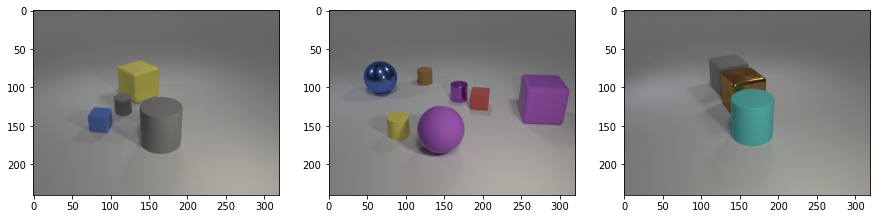

In [ ]:
import matplotlib.pyplot as plt
import torch

# Define a new figure
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)

# Print some images
for idx, (images, masks, counts) in enumerate(train_loader):
    if idx >= 0 and idx <= 2:
        # Print the images
        plt.subplot(1, 3, idx + 1)
        plt.imshow(images[0].to(torch.uint8).permute(1, 2, 0))

# Show the plot
plt.show()

In [ ]:
# Define the datasets for both training and testing
test_dataset = SegmentationDataset(mode='test')
train_dataset = SegmentationDataset(mode='train')

In [ ]:
# Define the dataloaders for both training and testing
test_loader = DataLoader(test_dataset, args.test_batch_size, args.shuffle)
train_loader = DataLoader(train_dataset, args.batch_size, args.shuffle)

In [ ]:
from src.Model.UNetCNN import UNetCNN
import torch

# Instantiate the model and send it to the GPU
model = UNetCNN(n_filters=args.n_filters).to(args.device)

# Define a custom optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=args.learn_rate, weight_decay=args.weight_decay)

# Specify a custom loss function
criterion = torch.nn.MSELoss()

In [ ]:
from src.Plotter import plot_loss
from src.Train import train

# Retain the loss evolution
losses_train = []

# Train the model for a number of epochs
for epoch in range(args.epochs):
    # Train the model for one epoch
    train_loss = train(model, train_loader, optimizer, criterion, epoch)

    # Retain the current loss
    losses_train.append(train_loss)

    # Separate the outputs
    print()

# Plot the loss evolution
plot_loss(losses_train, 'train_loss', 'Train Loss', 'Epoch', 'Loss')

In [ ]:
# Save the weights on disk
torch.save(model.state_dict(), args.model_weights)

In [ ]:
# Instantiate the model and send it to the GPU
model = UNetCNN(n_filters=args.n_filters).to(args.device)

# Load the model trained parameters in memory
model.load_state_dict(torch.load(args.model_weights))

<All keys matched successfully>

Loaded ./data/input/train_test_clevr_pkls/test_clevr_8000.pkl in memory.


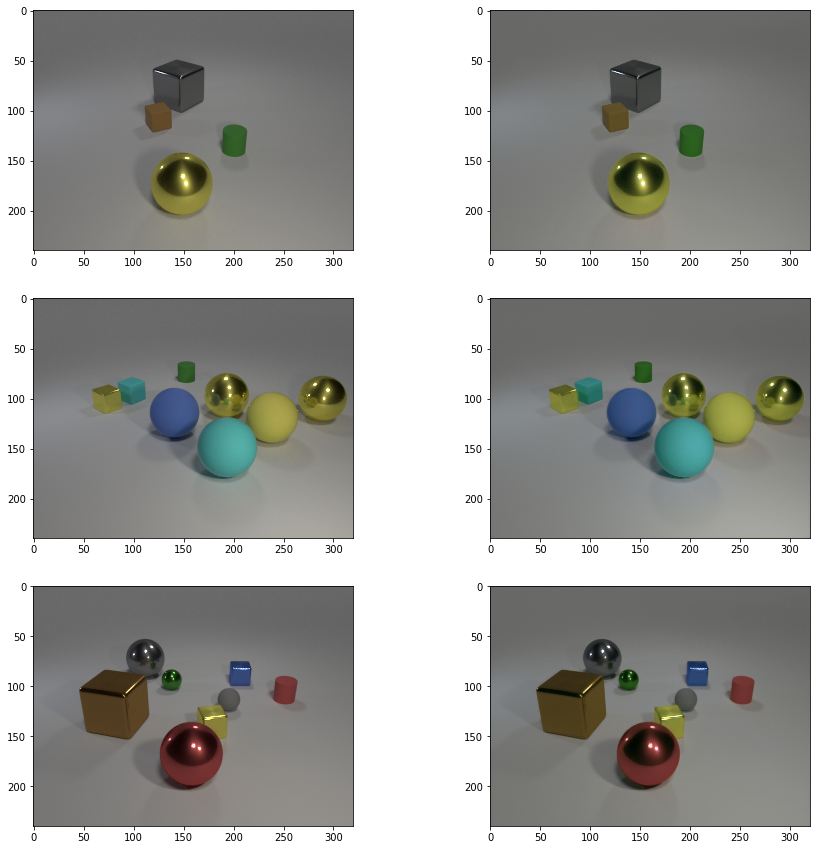

In [ ]:
from src.Process import unprocess, preprocess
import matplotlib.pyplot as plt

# Set the model to evaluation mode
model.eval()

# Create a new figure
f = plt.figure()
f.set_figheight(15)
f.set_figwidth(15)

# Set the number of samples
current_subplot = 1
total_subplots = 3

for batch_idx, (images, masks, counts) in enumerate(test_loader):
    if batch_idx == total_subplots:
        break

    # Specify the input image
    img_true = images[0]

    # Calculate the predicted image and transform it from [0, 1] -> [0, 255]
    img_pred = unprocess(model(preprocess(img_true).to(args.device).unsqueeze(0))).cpu()
    
    # Plot input image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_true.permute(1, 2, 0))
    current_subplot += 1

    # Plot output image
    plt.subplot(total_subplots, 2, current_subplot)
    plt.imshow(img_pred.squeeze(0).permute(1, 2, 0))
    current_subplot += 1

# Plot the images
plt.show()

Size of image: torch.Size([76800, 3])
Object count: 4


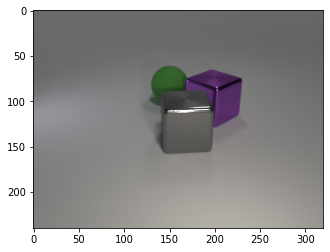

In [ ]:
import random

# Fetch entry
index = int(random.uniform(0, 1000))
image, mask, count = test_dataset[index]

# Store original image
original = image.clone()

# Pass through model
image = unprocess(model(preprocess(image.unsqueeze(0).to(args.device)))).squeeze(0)

# Reshape image
image = image.permute(1, 2, 0).to(torch.float)
image = image.reshape(-1, image.shape[2])

# Format object count
count = count.to(torch.int).item()

plt.imshow(original.permute(1, 2, 0))
print(f'Size of image: {image.shape}')
print(f'Object count: {count}')

K-means for the cosine similarity with 76,800 points in dimension 3, K = 4:
{0, 1, 2, 3}
4


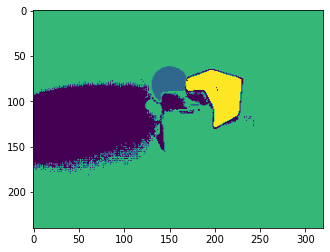

In [ ]:
from src.KMeans import KMeans_cosine

cl, c = KMeans_cosine(image.contiguous().to(args.device), K=count, n_init=10, max_iter=100, tol=1e-4, verbose=True)
plt.imshow(cl.cpu().reshape((240, 320)))
print(set(cl.cpu().numpy().tolist()))
print(count)